In [1]:
import os
import os.path as op
import sys
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from bluemath_tk.datamining.lhs import LHS 
from bluemath_tk.datamining.mda import MDA 
from bluemath_tk.wrappers.xbeach.xbeach_wrapper import XBeachModelWrapper

#### MDA

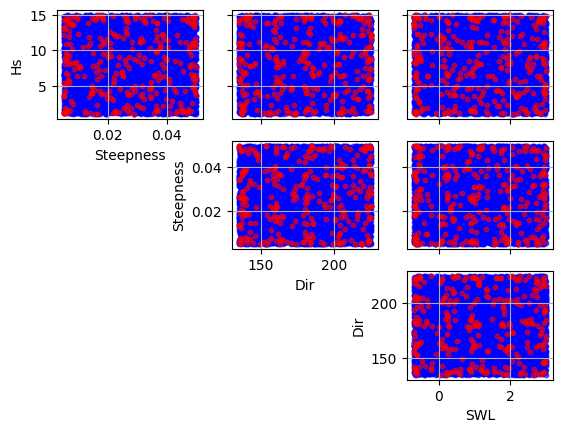

In [2]:
#### LHS and MDA 

var_names = ['Hs', 'Steepness', 'Dir', 'SWL']

lhs_parameters = {
    "num_dimensions": 4,
    "num_samples": 10000,
    "dimensions_names": var_names,
    "lower_bounds": [1, 0.005, 135, -0.7],
    "upper_bounds": [15, 0.05, 225,  3.0],
}

lhs = LHS(num_dimensions=lhs_parameters.get("num_dimensions"), seed=0)

df_dataset = lhs.generate(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
    num_samples=lhs_parameters.get("num_samples"),
)

mda_parameters = {"num_centers": 300}

mda = MDA(num_centers=mda_parameters.get("num_centers"))
mda.logger.disabled = True
mda.fit(data=df_dataset,normalize_data=True)
mda.plot_selected_centroids()
plt.show()

In [3]:
df_dataset['Tp'] = np.sqrt((df_dataset.Hs.values*2*np.pi)/(9.81*df_dataset.Steepness.values))
mda.centroids['Tp'] = np.sqrt((mda.centroids.Hs.values*2*np.pi)/(9.81*mda.centroids.Steepness.values))

mda_df = mda.centroids.copy()
mda_df['Dir'] = mda_df['Dir'].values + 180
mda_df['Dir'] = np.where(mda_df['Dir'] > 360, mda_df['Dir'] - 360, mda_df['Dir'])

#### Wrapper

In [4]:
model_params = mda.centroids[['Hs', 'Tp', 'Dir', 'SWL']].to_dict(orient="list")

In [ ]:
# Usage example
templates_dir = (
    "/home/grupos/geocean/alonsoap/BlueMath/methods/hybrid_downscaling/metamodels/HyBeat/templates"
)
templates_name = ["params.txt", "UX01_Ax10.dep", "UX01_Ax10.grd", "UX01_Ax10_cf.txt", "UX01_Ax10_fw.txt"]
model_parameters = model_params
output_dir = "/lustre/geocean/WORK/users/Pablo/XBeachCases"
# Create an instance of the XBEACH model wrapper
xbeach_model = XBeachModelWrapper(
    templates_dir=templates_dir,
    templates_name=templates_name,
    metamodel_parameters=model_parameters,
    fixed_parameters={'comptime':14400,
                      'wbctype':'jonstable'},
    output_dir=output_dir,
)
# Build the input files
#xbeach_model.build_cases(
#    mode="one_by_one")
#xbeach_model.run_cases()

2025-06-03 16:44:27,569 - XBeachModelWrapper - WARNING - Parameter Hs is not in the default_parameters
2025-06-03 16:44:27,570 - XBeachModelWrapper - WARNING - Parameter Tp is not in the default_parameters
2025-06-03 16:44:27,570 - XBeachModelWrapper - WARNING - Parameter Dir is not in the default_parameters
2025-06-03 16:44:27,570 - XBeachModelWrapper - WARNING - Parameter SWL is not in the default_parameters


#### Post-process the results

In [6]:
xbeach_model.load_cases()
xbeach_results = xbeach_model.postprocess_cases(output_vars = ['zs_mean','zs_var'])

In [7]:
xbeach_results.to_netcdf('/lustre/geocean/WORK/users/Pablo/XBeachCases/case_library.nc')

In [11]:
mda_df.to_csv('/home/grupos/geocean/alonsoap/BlueMath/methods/hybrid_downscaling/metamodels/HyBeat/assets/mda_df.csv')

import pickle

# Let's say your model is called `model`
with open("assets/xbeach_model.pkl", "wb") as f:
    pickle.dump(xbeach_model, f)